In [1]:
import numpy as np
import os, random
from PIL import Image
import json
import glob
import matplotlib.pyplot as plt

## log 파일 읽고 그래프 그리기

In [2]:
def read_avg_after_avg_line(file_path):
    avg_value = None

    # 파일 열기
    with open(file_path, 'r') as file:
        # 파일의 모든 줄을 읽기
        lines = file.readlines()
        # 마지막 줄부터 역순으로 확인
        for i in range(len(lines) - 1):  # -1로 마지막 줄을 제외
            line = lines[i].strip()  # 공백 제거
            if line.startswith("AVG"):
                # 다음 줄의 숫자 읽기
                next_line = lines[i + 1].strip()  # 다음 줄
                avg_value = next_line  # 다음 줄의 값

    return float(avg_value) if avg_value is not None else None

In [3]:
# imagenet_mean = 0.448
# imagenet_std = 0.226

def make_image_format_v1(tensor, wp_mean, wp_std, c):
    tensor = (tensor - wp_mean) / wp_std
    tensor = tensor * imagenet_std * c + imagenet_mean
    tensor = np.clip(tensor, 0, 1)
    tensor = tensor * 255  # Grayscale image data (100x100 pixels)
    tensor = tensor.astype(np.uint8)
    return tensor

def reverse_image_format_v1(tensor, wp_mean, wp_std, c):
    # uint8에서 float로 변환하고 255로 나누어 0-1 범위로 정규화
    tensor = tensor.astype(np.float32) / 255.0
    
    # 클리핑을 무시하므로 클리핑 이전의 값으로 가정
    tensor = tensor - imagenet_mean  # imagenet_mean을 빼기
    tensor = tensor / (imagenet_std * c)  # (imagenet_std * c)로 나누기
    tensor = tensor * wp_std + wp_mean  # wp_std로 곱하고 wp_mean을 더하기
    return tensor


def make_image_format(w, mu, s, t):
    th = t * s
    w = np.clip(w, mu - th, mu + th)
    w = 255 * (w - mu + th) / (2 * th)
    w = w.astype(np.uint8)
    return w

def reverse_image_format(w, mu, s, t):
    th = t * s
    # w를 float 타입으로 변환하여 역연산
    w = w.astype(np.float64)
    # [0, 255] 범위를 [mu - th, mu + th] 범위로 되돌리기
    w = (w / 255) * (2 * th) + (mu - th)
    return w

def calculate_mse(array1, array2):
    # 두 배열의 차이를 계산
    difference = array1 - array2
    # 차이의 제곱을 계산
    squared_difference = np.square(difference)
    # 제곱된 차이의 평균을 계산
    mse = np.mean(squared_difference)
    return mse

from PIL import Image
import numpy as np

def png_to_numpy_array(file_path):
    # PNG 파일 읽기
    image = Image.open(file_path)
    # 이미지를 NumPy 배열로 변환
    image_array = np.array(image)
    return image_array

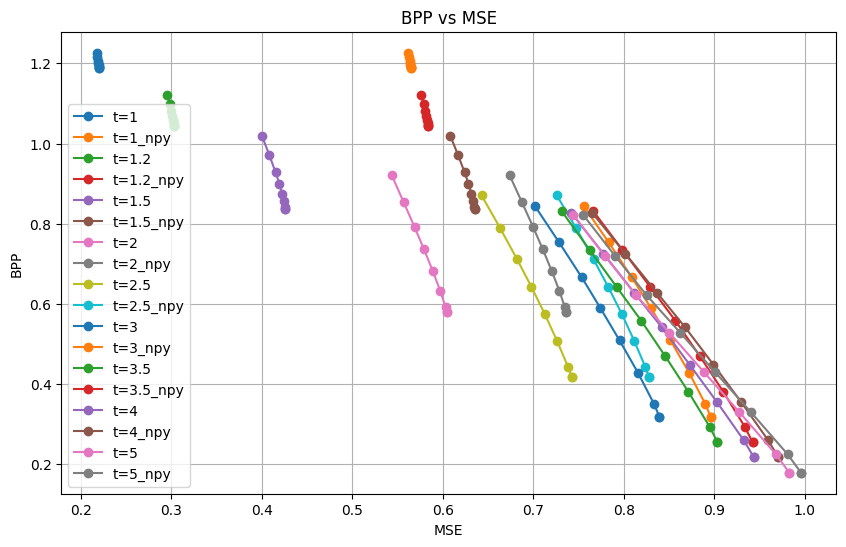

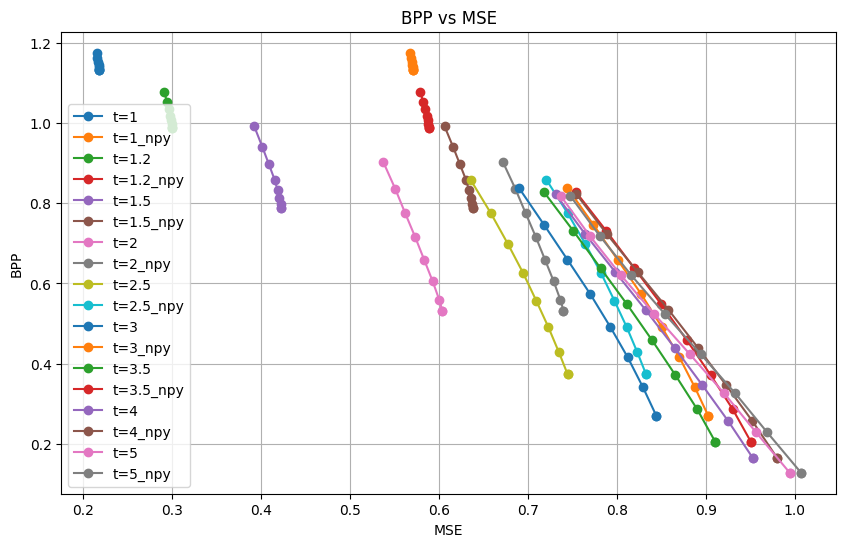

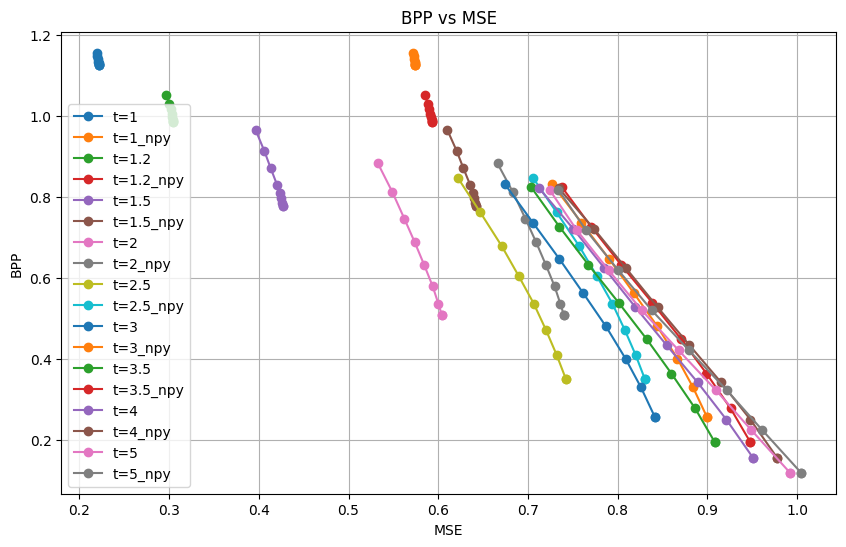

In [9]:
type = 'attn'
for dim in [32, 64, 256]:
# for dim in [512, 1024]:
    source_npy_path = f'/home/jgryu/Weight_compression/JPEG/wp_npy/meta-llama-3-8b_{type}_val_json/{dim}_{dim}'
    source_img_path = f'/home/jgryu/Weight_compression/JPEG/wp_image/meta-llama-3-8b_{type}_val_json/{dim}_{dim}'
    result_img_path = f'/home/jgryu/Weight_compression/JPEG/wp_image_result/meta-llama-3-8b_{type}_val_json/{dim}_{dim}'
    log_file_path = f'/home/jgryu/Weight_compression/JPEG/logs/meta-llama-3-8b_{type}_val_json/{dim}_{dim}'
    json_path = f'/home/jgryu/Weight_compression/JPEG/results/meta-llama-3-8b_{type}_val_json/{dim}_{dim}'

    data = {}

    mean = np.load(source_npy_path + '/mean_value.npy')
    std = np.load(source_npy_path + '/std_value.npy')


    # for c in [0.1, 0.3, 0.5, 0.7, 1, 1.5, 2, 3]:
    for t in [1, 1.2, 1.5, 2, 2.5, 3, 3.5, 4, 5]:
        mses = []
        mses_npy = []
        bpps = []
        for bpp in [0.1, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]:
            source_path = source_img_path + f'/t={t}'
            result_path = result_img_path + f'/t={t}/bpp{bpp}'

            mse_list = []
            mse_from_npy = []
            N = len(os.listdir(source_path))
            for i in range(N):  # files는 미리 정의된 리스트라고 가정
                path = source_path + f'/{i}.png'
                before = png_to_numpy_array(path)
                before = reverse_image_format(before, mu=mean, s=std, t=t)
                before_npy = np.load(source_npy_path + f'/{i}.npy')
                
                path = result_path + f'/{i}.jpg'
                after = png_to_numpy_array(path)
                after = reverse_image_format(after, mu=mean, s=std, t=t)

                mse_list.append(calculate_mse(before, after))
                mse_from_npy.append(calculate_mse(before_npy, after))

            average_mse = np.mean(mse_list) / std**2
            average_mse_npy = np.mean(mse_from_npy) / std**2
            # print("MSE:", average_mse)
            # print("MSE_from_npy:", average_mse_npy)

            mses.append(average_mse)
            mses_npy.append(average_mse_npy)
            log_file = log_file_path + f'/log_t={t}_bpp{bpp}.txt'
            last_avg_result = read_avg_after_avg_line(log_file)
            # print(f"Bpp: {last_avg_result}")
            bpps.append(last_avg_result)

        # 데이터 저장
        data[f't={t}'] = {'mses': mses, 'mse_from_npy': mses_npy, 'bpps': bpps}

    os.makedirs(json_path, exist_ok=True)
    with open(json_path + '/results.json', 'w') as json_file:
        json.dump(data, json_file, indent=4)  
    # MSE 대 BPP 그래프 그리기
    plt.figure(figsize=(10, 6))
    for t, values in data.items():
        plt.plot(values['mses'], values['bpps'], marker='o', label=t)
        plt.plot(values['mse_from_npy'], values['bpps'], marker='o', label=t + '_npy')

    plt.title('BPP vs MSE')
    plt.xlabel('MSE')
    plt.ylabel('BPP')
    # plt.xticks(np.arange(0, max(mses) + 0.01, 0.01))  # MSE의 범위를 조정
    plt.grid()
    plt.legend()
    plt.show()

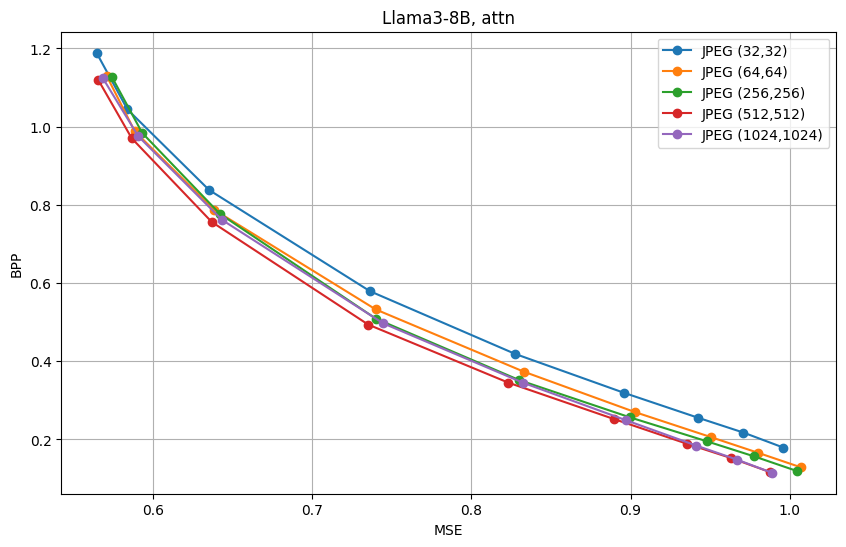

In [10]:
plt.figure(figsize=(10, 6))
for dim in [32, 64, 256, 512, 1024]:
    json_path = f'/home/jgryu/Weight_compression/JPEG/results/meta-llama-3-8b_{type}_val_json/{dim}_{dim}/results.json'
    with open(json_path, 'r') as json_file:
        jpeg_data = json.load(json_file)
        
    mse_list = []
    mse_npy_list = []
    bpp_list = []
    for c, values in jpeg_data.items():
        mse_list.append(values['mses'][0])
        mse_npy_list.append(values['mse_from_npy'][0])
        bpp_list.append(values['bpps'][0])
        
    
    # plot_data['jpeg, d256x256'] = {'val_mse': mse_npy_list, 'val_rate':bpp_list, 'mse': mse_npy_list, 'rate': bpp_list}
    plt.plot(mse_npy_list, bpp_list, marker='o', label=f'JPEG ({dim},{dim})')
    
plt.title(f'Llama3-8B, {type}')
plt.xlabel('MSE')
plt.ylabel('BPP')
# plt.xticks(np.arange(0, max(mses) + 0.01, 0.01))  # MSE의 범위를 조정
plt.grid()
plt.legend()
plt.show()

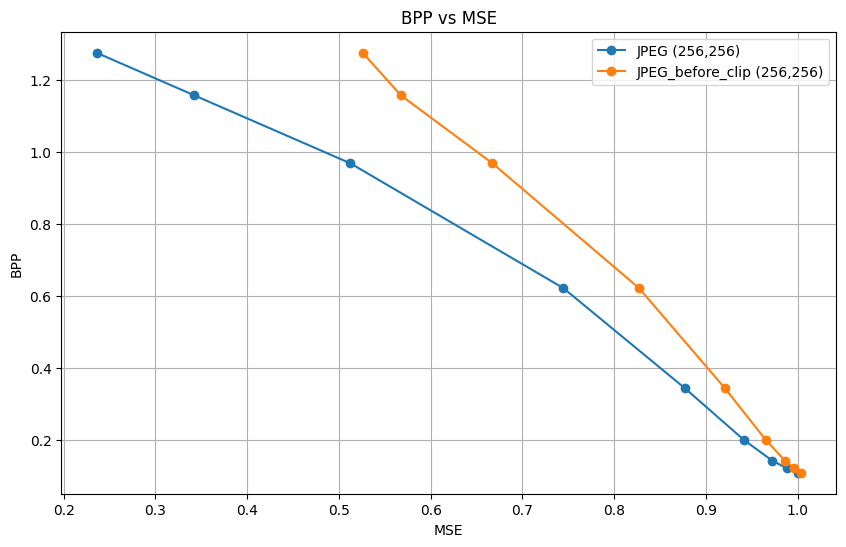

In [ ]:
mse_list = []
mse_npy_list = []
bpp_list = []
for c, values in data.items():
    mse_list.append(values['mses'][0])
    mse_npy_list.append(values['mse_from_npy'][0])
    bpp_list.append(values['bpps'][0])
    
    # plt.plot(values['mses'], values['bpps'], marker='o', label=f'c={c}')

plt.figure(figsize=(10, 6))
plt.plot(mse_list, bpp_list, marker='o', label=f'JPEG ({dim},256)')
plt.plot(mse_npy_list, bpp_list, marker='o', label=f'JPEG_before_clip (256,256)')

plt.title('BPP vs MSE')
plt.xlabel('MSE')
plt.ylabel('BPP')
# plt.xticks(np.arange(0, max(mses) + 0.01, 0.01))  # MSE의 범위를 조정
plt.grid()
plt.legend()
plt.show()

In [ ]:
for i in range(len(mse_list)):
    print(mse_npy_list[i], bpp_list[i])

0.00014613794 0.426707763671875
0.00014669629 0.4325718994140625
0.00014704333 0.559120361328125
0.00013494283 0.736552490234375
0.000112696354 0.9881512451171875
9.3104405e-05 1.2137393798828124


In [ ]:
for i in range(len(mse_list)):
    print(mse_list[i], bpp_list[i])

0.00014511003 0.426707763671875
0.00014328405 0.4325718994140625
0.00013564229 0.559120361328125
0.00011696918 0.736552490234375
8.468635e-05 0.9881512451171875
4.9290877e-05 1.2137393798828124
